##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# Load and preprocess images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using tf.data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2023-01-13 02:21:47.621249: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-13 02:21:47.621371: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-13 02:21:47.621382: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [3]:
print(tf.__version__)

2.11.0


### Download the flowers dataset

This tutorial uses a dataset of several thousand photos of flowers. The flowers dataset contains five sub-directories, one per class:

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

Note: all images are licensed CC-BY, creators are listed in the LICENSE.txt file.

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

     8192/228813984 [..............................] - ETA: 0s

  8396800/228813984 [>.............................] - ETA: 1s

 19136512/228813984 [=>............................] - ETA: 1s

 33562624/228813984 [===>..........................] - ETA: 1s

 41951232/228813984 [====>.........................] - ETA: 1s

 56336384/228813984 [======>.......................] - ETA: 0s

 70631424/228813984 [========>.....................] - ETA: 0s

 85327872/228813984 [==========>...................] - ETA: 0s

 92282880/228813984 [===========>..................] - ETA: 0s

106708992/228813984 [============>.................] - ETA: 0s

121610240/228813984 [==============>...............] - ETA: 0s

136273920/228813984 [================>.............] - ETA: 0s

144449536/228813984 [=================>............] - ETA: 0s

159014912/228813984 [===================>..........] - ETA: 0s

167780352/228813984 [====================>.........] - ETA: 0s

177684480/228813984 [======================>.......] - ETA: 0s

188637184/228813984 [=======================>......] - ETA: 0s

196812800/228813984 [========================>.....] - ETA: 0s

207757312/228813984 [==========================>...] - ETA: 0s

218628096/228813984 [===========================>..] - ETA: 0s

228813984/228813984 [==============================] - 1s 0us/step


After downloading (218MB), you should now have a copy of the flower photos available. There are 3,670 total images:

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Each directory contains images of that type of flower. Here are some roses:

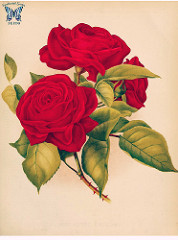

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

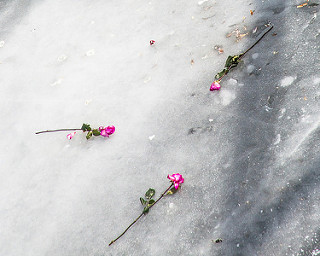

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### Visualize the data

Here are the first nine images from the training dataset.

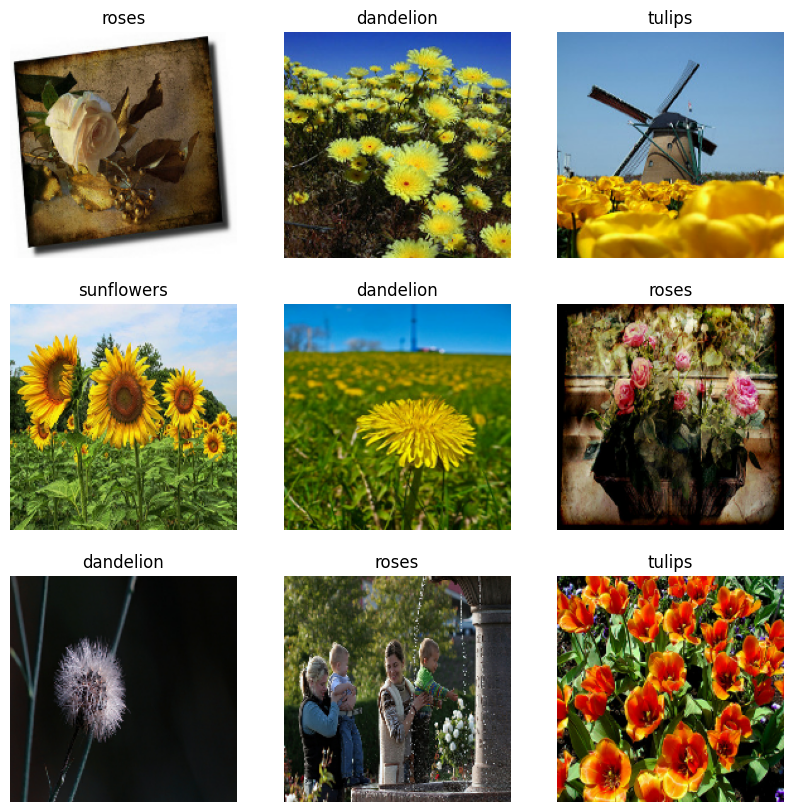

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


0.0 0.96902645


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `tf.keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [17]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [19]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 12:57 - loss: 1.6243 - accuracy: 0.1562

 4/92 [>.............................] - ETA: 1s - loss: 1.7141 - accuracy: 0.2031   

 7/92 [=>............................] - ETA: 1s - loss: 1.6921 - accuracy: 0.2366

10/92 [==>...........................] - ETA: 1s - loss: 1.6458 - accuracy: 0.2625

13/92 [===>..........................] - ETA: 1s - loss: 1.6137 - accuracy: 0.3005

16/92 [====>.........................] - ETA: 1s - loss: 1.5796 - accuracy: 0.3105

19/92 [=====>........................] - ETA: 1s - loss: 1.5584 - accuracy: 0.3224

22/92 [======>.......................] - ETA: 1s - loss: 1.5226 - accuracy: 0.3466

25/92 [=======>......................] - ETA: 1s - loss: 1.4989 - accuracy: 0.3587

28/92 [========>.....................] - ETA: 1s - loss: 1.4689 - accuracy: 0.3795

31/92 [=========>....................] - ETA: 1s - loss: 1.4519 - accuracy: 0.3881

34/92 [==========>...................] - ETA: 0s - loss: 1.4224 - accuracy: 0.3925

37/92 [===========>..................] - ETA: 0s - loss: 1.3940 - accuracy: 0.4046

40/92 [============>.................] - ETA: 0s - loss: 1.3774 - accuracy: 0.4141

43/92 [=============>................] - ETA: 0s - loss: 1.3563 - accuracy: 0.4230

46/92 [==============>...............] - ETA: 0s - loss: 1.3519 - accuracy: 0.4239

49/92 [==============>...............] - ETA: 0s - loss: 1.3458 - accuracy: 0.4267

52/92 [===============>..............] - ETA: 0s - loss: 1.3423 - accuracy: 0.4261

55/92 [================>.............] - ETA: 0s - loss: 1.3340 - accuracy: 0.4301

58/92 [=================>............] - ETA: 0s - loss: 1.3338 - accuracy: 0.4283

61/92 [==================>...........] - ETA: 0s - loss: 1.3239 - accuracy: 0.4344

64/92 [===================>..........] - ETA: 0s - loss: 1.3121 - accuracy: 0.4429

67/92 [====================>.........] - ETA: 0s - loss: 1.2991 - accuracy: 0.4478

70/92 [=====================>........] - ETA: 0s - loss: 1.2961 - accuracy: 0.4469

73/92 [======================>.......] - ETA: 0s - loss: 1.2814 - accuracy: 0.4525

76/92 [=======================>......] - ETA: 0s - loss: 1.2807 - accuracy: 0.4564

79/92 [========================>.....] - ETA: 0s - loss: 1.2766 - accuracy: 0.4581

82/92 [=========================>....] - ETA: 0s - loss: 1.2746 - accuracy: 0.4577

85/92 [==========================>...] - ETA: 0s - loss: 1.2685 - accuracy: 0.4603

88/92 [===========================>..] - ETA: 0s - loss: 1.2638 - accuracy: 0.4627

91/92 [============================>.] - ETA: 0s - loss: 1.2667 - accuracy: 0.4598

92/92 [==============================] - ETA: 0s - loss: 1.2676 - accuracy: 0.4588

92/92 [==============================] - 11s 23ms/step - loss: 1.2676 - accuracy: 0.4588 - val_loss: 1.0554 - val_accuracy: 0.5722


Epoch 2/3


 1/92 [..............................] - ETA: 1s - loss: 1.0572 - accuracy: 0.5938

 4/92 [>.............................] - ETA: 1s - loss: 1.0055 - accuracy: 0.6094

 7/92 [=>............................] - ETA: 1s - loss: 1.0414 - accuracy: 0.5893

10/92 [==>...........................] - ETA: 1s - loss: 1.0496 - accuracy: 0.5594

13/92 [===>..........................] - ETA: 1s - loss: 1.0605 - accuracy: 0.5481

16/92 [====>.........................] - ETA: 1s - loss: 1.0407 - accuracy: 0.5645

19/92 [=====>........................] - ETA: 1s - loss: 1.0416 - accuracy: 0.5658

22/92 [======>.......................] - ETA: 1s - loss: 1.0270 - accuracy: 0.5682

25/92 [=======>......................] - ETA: 1s - loss: 1.0481 - accuracy: 0.5700

28/92 [========>.....................] - ETA: 1s - loss: 1.0437 - accuracy: 0.5770

31/92 [=========>....................] - ETA: 1s - loss: 1.0502 - accuracy: 0.5796

34/92 [==========>...................] - ETA: 0s - loss: 1.0409 - accuracy: 0.5781

37/92 [===========>..................] - ETA: 0s - loss: 1.0255 - accuracy: 0.5870

40/92 [============>.................] - ETA: 0s - loss: 1.0240 - accuracy: 0.5875

43/92 [=============>................] - ETA: 0s - loss: 1.0211 - accuracy: 0.5887

46/92 [==============>...............] - ETA: 0s - loss: 1.0301 - accuracy: 0.5876

49/92 [==============>...............] - ETA: 0s - loss: 1.0346 - accuracy: 0.5829

52/92 [===============>..............] - ETA: 0s - loss: 1.0380 - accuracy: 0.5805

55/92 [================>.............] - ETA: 0s - loss: 1.0378 - accuracy: 0.5773

58/92 [=================>............] - ETA: 0s - loss: 1.0465 - accuracy: 0.5722

61/92 [==================>...........] - ETA: 0s - loss: 1.0434 - accuracy: 0.5779

64/92 [===================>..........] - ETA: 0s - loss: 1.0384 - accuracy: 0.5825

67/92 [====================>.........] - ETA: 0s - loss: 1.0308 - accuracy: 0.5863

70/92 [=====================>........] - ETA: 0s - loss: 1.0321 - accuracy: 0.5848

73/92 [======================>.......] - ETA: 0s - loss: 1.0232 - accuracy: 0.5903

76/92 [=======================>......] - ETA: 0s - loss: 1.0258 - accuracy: 0.5917

79/92 [========================>.....] - ETA: 0s - loss: 1.0255 - accuracy: 0.5918

82/92 [=========================>....] - ETA: 0s - loss: 1.0277 - accuracy: 0.5899

85/92 [==========================>...] - ETA: 0s - loss: 1.0240 - accuracy: 0.5901

88/92 [===========================>..] - ETA: 0s - loss: 1.0237 - accuracy: 0.5913

91/92 [============================>.] - ETA: 0s - loss: 1.0310 - accuracy: 0.5883

92/92 [==============================] - 2s 20ms/step - loss: 1.0322 - accuracy: 0.5869 - val_loss: 0.9720 - val_accuracy: 0.6172


Epoch 3/3


 1/92 [..............................] - ETA: 1s - loss: 0.9875 - accuracy: 0.5938

 4/92 [>.............................] - ETA: 1s - loss: 0.8720 - accuracy: 0.6953

 7/92 [=>............................] - ETA: 1s - loss: 0.9035 - accuracy: 0.6741

10/92 [==>...........................] - ETA: 1s - loss: 0.9046 - accuracy: 0.6719

13/92 [===>..........................] - ETA: 1s - loss: 0.9165 - accuracy: 0.6442

16/92 [====>.........................] - ETA: 1s - loss: 0.9009 - accuracy: 0.6543

19/92 [=====>........................] - ETA: 1s - loss: 0.8972 - accuracy: 0.6513

22/92 [======>.......................] - ETA: 1s - loss: 0.8763 - accuracy: 0.6577

25/92 [=======>......................] - ETA: 1s - loss: 0.8940 - accuracy: 0.6562

28/92 [========>.....................] - ETA: 1s - loss: 0.8854 - accuracy: 0.6629

31/92 [=========>....................] - ETA: 1s - loss: 0.8963 - accuracy: 0.6562

34/92 [==========>...................] - ETA: 0s - loss: 0.8935 - accuracy: 0.6498

37/92 [===========>..................] - ETA: 0s - loss: 0.8858 - accuracy: 0.6554

40/92 [============>.................] - ETA: 0s - loss: 0.8830 - accuracy: 0.6562

43/92 [=============>................] - ETA: 0s - loss: 0.8829 - accuracy: 0.6555

46/92 [==============>...............] - ETA: 0s - loss: 0.8916 - accuracy: 0.6501

49/92 [==============>...............] - ETA: 0s - loss: 0.8981 - accuracy: 0.6460

52/92 [===============>..............] - ETA: 0s - loss: 0.9041 - accuracy: 0.6442

55/92 [================>.............] - ETA: 0s - loss: 0.9042 - accuracy: 0.6432

58/92 [=================>............] - ETA: 0s - loss: 0.9126 - accuracy: 0.6379

61/92 [==================>...........] - ETA: 0s - loss: 0.9089 - accuracy: 0.6414

64/92 [===================>..........] - ETA: 0s - loss: 0.9030 - accuracy: 0.6445

67/92 [====================>.........] - ETA: 0s - loss: 0.8932 - accuracy: 0.6483

70/92 [=====================>........] - ETA: 0s - loss: 0.8961 - accuracy: 0.6460

73/92 [======================>.......] - ETA: 0s - loss: 0.8870 - accuracy: 0.6503

76/92 [=======================>......] - ETA: 0s - loss: 0.8882 - accuracy: 0.6501

79/92 [========================>.....] - ETA: 0s - loss: 0.8852 - accuracy: 0.6503

82/92 [=========================>....] - ETA: 0s - loss: 0.8849 - accuracy: 0.6498

85/92 [==========================>...] - ETA: 0s - loss: 0.8802 - accuracy: 0.6522

88/92 [===========================>..] - ETA: 0s - loss: 0.8814 - accuracy: 0.6538

91/92 [============================>.] - ETA: 0s - loss: 0.8854 - accuracy: 0.6511

92/92 [==============================] - 2s 20ms/step - loss: 0.8855 - accuracy: 0.6502 - val_loss: 0.9038 - val_accuracy: 0.6471


Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

You may notice the validation accuracy is low compared to the training accuracy, indicating your model is overfitting. You can learn more about overfitting and how to reduce it in this [tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

## Using tf.data for finer control

The above Keras preprocessing utility—`tf.keras.utils.image_dataset_from_directory`—is a convenient way to create a `tf.data.Dataset` from a directory of images.

For finer grain control, you can write your own input pipeline using `tf.data`. This section shows how to do just that, beginning with the file paths from the TGZ file you downloaded earlier.

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [21]:
for f in list_ds.take(5):
  print(f.numpy())

b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/14164392167_650946a169_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/3628485766_4ff937954a_n.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/14221836990_90374e6b34.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/dandelion/6972675188_37f1f1d6f6.jpg'
b'/home/kbuilder/.keras/datasets/flower_photos/daisy/2213954589_c7da4b1486.jpg'


The tree structure of the files can be used to compile a `class_names` list.

In [22]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


Split the dataset into training and validation sets:

In [23]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

You can print the length of each dataset as follows:

In [24]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


Write a short function that converts a file path to an `(img, label)` pair:

In [25]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [26]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [27]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Use `Dataset.map` to create a dataset of `image, label` pairs:

In [28]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [29]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


### Configure dataset for performance

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be added using the `tf.data` API. For more details, visit the [Input Pipeline Performance](../../guide/performance/datasets.ipynb) guide.

In [30]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### Visualize the data

You can visualize this dataset similarly to the one you created previously:

2023-01-13 02:22:13.540045: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


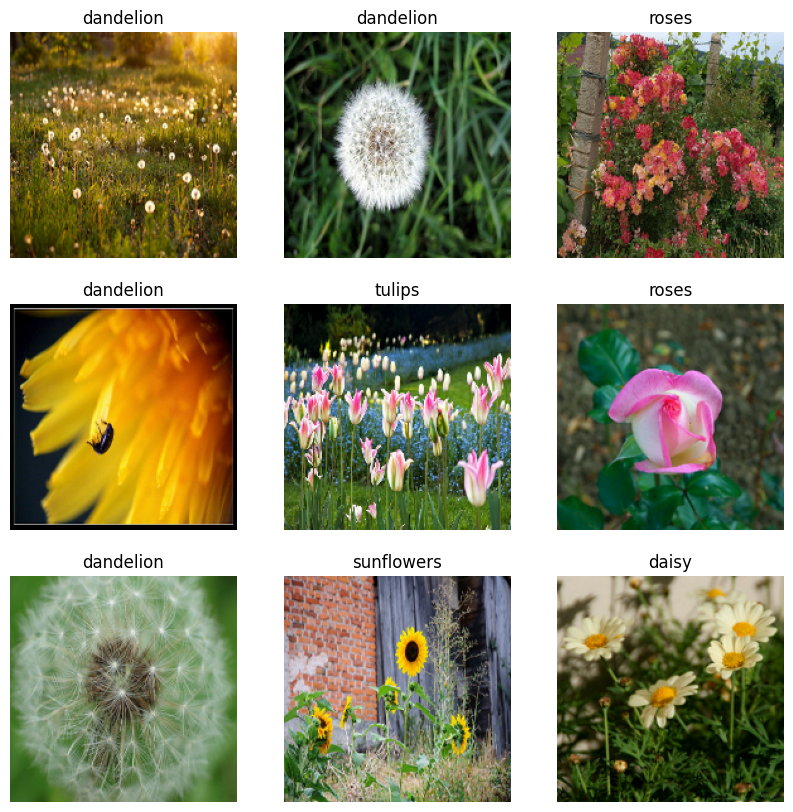

In [31]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### Continue training the model

You have now manually built a similar `tf.data.Dataset` to the one created by `tf.keras.utils.image_dataset_from_directory` above. You can continue training the model with it. As before, you will train for just a few epochs to keep the running time short.

In [32]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3


 1/92 [..............................] - ETA: 49s - loss: 0.7119 - accuracy: 0.7500

 4/92 [>.............................] - ETA: 1s - loss: 0.7834 - accuracy: 0.7031 

 7/92 [=>............................] - ETA: 1s - loss: 0.7994 - accuracy: 0.6920

10/92 [==>...........................] - ETA: 1s - loss: 0.7850 - accuracy: 0.6844

13/92 [===>..........................] - ETA: 1s - loss: 0.7753 - accuracy: 0.7067

16/92 [====>.........................] - ETA: 1s - loss: 0.7658 - accuracy: 0.7090

19/92 [=====>........................] - ETA: 1s - loss: 0.7625 - accuracy: 0.7122

22/92 [======>.......................] - ETA: 1s - loss: 0.7737 - accuracy: 0.7102

25/92 [=======>......................] - ETA: 1s - loss: 0.7874 - accuracy: 0.7013

28/92 [========>.....................] - ETA: 1s - loss: 0.7821 - accuracy: 0.7020

31/92 [=========>....................] - ETA: 1s - loss: 0.7760 - accuracy: 0.7056

34/92 [==========>...................] - ETA: 0s - loss: 0.7738 - accuracy: 0.7096

37/92 [===========>..................] - ETA: 0s - loss: 0.7772 - accuracy: 0.7103

40/92 [============>.................] - ETA: 0s - loss: 0.7670 - accuracy: 0.7156

43/92 [=============>................] - ETA: 0s - loss: 0.7608 - accuracy: 0.7166

46/92 [==============>...............] - ETA: 0s - loss: 0.7637 - accuracy: 0.7106

49/92 [==============>...............] - ETA: 0s - loss: 0.7715 - accuracy: 0.7073

52/92 [===============>..............] - ETA: 0s - loss: 0.7665 - accuracy: 0.7091

55/92 [================>.............] - ETA: 0s - loss: 0.7707 - accuracy: 0.7057

58/92 [=================>............] - ETA: 0s - loss: 0.7678 - accuracy: 0.7074

61/92 [==================>...........] - ETA: 0s - loss: 0.7620 - accuracy: 0.7111

64/92 [===================>..........] - ETA: 0s - loss: 0.7592 - accuracy: 0.7124

67/92 [====================>.........] - ETA: 0s - loss: 0.7568 - accuracy: 0.7108

70/92 [=====================>........] - ETA: 0s - loss: 0.7492 - accuracy: 0.7138

73/92 [======================>.......] - ETA: 0s - loss: 0.7467 - accuracy: 0.7153

76/92 [=======================>......] - ETA: 0s - loss: 0.7498 - accuracy: 0.7159

79/92 [========================>.....] - ETA: 0s - loss: 0.7527 - accuracy: 0.7152

82/92 [=========================>....] - ETA: 0s - loss: 0.7540 - accuracy: 0.7134

85/92 [==========================>...] - ETA: 0s - loss: 0.7550 - accuracy: 0.7132

88/92 [===========================>..] - ETA: 0s - loss: 0.7592 - accuracy: 0.7116

91/92 [============================>.] - ETA: 0s - loss: 0.7587 - accuracy: 0.7115

92/92 [==============================] - 3s 23ms/step - loss: 0.7589 - accuracy: 0.7119 - val_loss: 0.7745 - val_accuracy: 0.7153


Epoch 2/3


 1/92 [..............................] - ETA: 1s - loss: 0.6968 - accuracy: 0.7188

 4/92 [>.............................] - ETA: 1s - loss: 0.7389 - accuracy: 0.7031

 7/92 [=>............................] - ETA: 1s - loss: 0.7490 - accuracy: 0.7054

10/92 [==>...........................] - ETA: 1s - loss: 0.6866 - accuracy: 0.7250

13/92 [===>..........................] - ETA: 1s - loss: 0.6619 - accuracy: 0.7356

16/92 [====>.........................] - ETA: 1s - loss: 0.6501 - accuracy: 0.7422

19/92 [=====>........................] - ETA: 1s - loss: 0.6374 - accuracy: 0.7516

22/92 [======>.......................] - ETA: 1s - loss: 0.6300 - accuracy: 0.7585

25/92 [=======>......................] - ETA: 1s - loss: 0.6200 - accuracy: 0.7638

28/92 [========>.....................] - ETA: 1s - loss: 0.6229 - accuracy: 0.7656

31/92 [=========>....................] - ETA: 1s - loss: 0.6245 - accuracy: 0.7641

34/92 [==========>...................] - ETA: 1s - loss: 0.6241 - accuracy: 0.7638

37/92 [===========>..................] - ETA: 0s - loss: 0.6165 - accuracy: 0.7677

40/92 [============>.................] - ETA: 0s - loss: 0.6109 - accuracy: 0.7719

43/92 [=============>................] - ETA: 0s - loss: 0.6212 - accuracy: 0.7718

46/92 [==============>...............] - ETA: 0s - loss: 0.6254 - accuracy: 0.7690

49/92 [==============>...............] - ETA: 0s - loss: 0.6188 - accuracy: 0.7710

52/92 [===============>..............] - ETA: 0s - loss: 0.6150 - accuracy: 0.7722

55/92 [================>.............] - ETA: 0s - loss: 0.6111 - accuracy: 0.7727

58/92 [=================>............] - ETA: 0s - loss: 0.6058 - accuracy: 0.7748

61/92 [==================>...........] - ETA: 0s - loss: 0.6040 - accuracy: 0.7761

64/92 [===================>..........] - ETA: 0s - loss: 0.6034 - accuracy: 0.7759

67/92 [====================>.........] - ETA: 0s - loss: 0.6073 - accuracy: 0.7719

70/92 [=====================>........] - ETA: 0s - loss: 0.6016 - accuracy: 0.7741

73/92 [======================>.......] - ETA: 0s - loss: 0.6018 - accuracy: 0.7744

76/92 [=======================>......] - ETA: 0s - loss: 0.5984 - accuracy: 0.7763

79/92 [========================>.....] - ETA: 0s - loss: 0.6022 - accuracy: 0.7749

82/92 [=========================>....] - ETA: 0s - loss: 0.6013 - accuracy: 0.7767

85/92 [==========================>...] - ETA: 0s - loss: 0.5970 - accuracy: 0.7787

88/92 [===========================>..] - ETA: 0s - loss: 0.5969 - accuracy: 0.7773

91/92 [============================>.] - ETA: 0s - loss: 0.6001 - accuracy: 0.7785

92/92 [==============================] - 2s 20ms/step - loss: 0.5993 - accuracy: 0.7796 - val_loss: 0.7251 - val_accuracy: 0.7180


Epoch 3/3


 1/92 [..............................] - ETA: 1s - loss: 0.3918 - accuracy: 0.8438

 4/92 [>.............................] - ETA: 1s - loss: 0.4780 - accuracy: 0.8125

 7/92 [=>............................] - ETA: 1s - loss: 0.4864 - accuracy: 0.8170

10/92 [==>...........................] - ETA: 1s - loss: 0.5315 - accuracy: 0.8062

13/92 [===>..........................] - ETA: 1s - loss: 0.4966 - accuracy: 0.8149

16/92 [====>.........................] - ETA: 1s - loss: 0.5057 - accuracy: 0.8105

19/92 [=====>........................] - ETA: 1s - loss: 0.4941 - accuracy: 0.8191

22/92 [======>.......................] - ETA: 1s - loss: 0.4960 - accuracy: 0.8182

25/92 [=======>......................] - ETA: 1s - loss: 0.4885 - accuracy: 0.8213

28/92 [========>.....................] - ETA: 1s - loss: 0.4671 - accuracy: 0.8315

31/92 [=========>....................] - ETA: 1s - loss: 0.4756 - accuracy: 0.8296

34/92 [==========>...................] - ETA: 1s - loss: 0.4748 - accuracy: 0.8272

37/92 [===========>..................] - ETA: 0s - loss: 0.4766 - accuracy: 0.8285

40/92 [============>.................] - ETA: 0s - loss: 0.4772 - accuracy: 0.8258

43/92 [=============>................] - ETA: 0s - loss: 0.4743 - accuracy: 0.8292

46/92 [==============>...............] - ETA: 0s - loss: 0.4721 - accuracy: 0.8274

49/92 [==============>...............] - ETA: 0s - loss: 0.4788 - accuracy: 0.8240

52/92 [===============>..............] - ETA: 0s - loss: 0.4752 - accuracy: 0.8263

55/92 [================>.............] - ETA: 0s - loss: 0.4688 - accuracy: 0.8284

58/92 [=================>............] - ETA: 0s - loss: 0.4681 - accuracy: 0.8281

61/92 [==================>...........] - ETA: 0s - loss: 0.4637 - accuracy: 0.8320

64/92 [===================>..........] - ETA: 0s - loss: 0.4601 - accuracy: 0.8325

67/92 [====================>.........] - ETA: 0s - loss: 0.4598 - accuracy: 0.8316

70/92 [=====================>........] - ETA: 0s - loss: 0.4578 - accuracy: 0.8317

73/92 [======================>.......] - ETA: 0s - loss: 0.4628 - accuracy: 0.8313

76/92 [=======================>......] - ETA: 0s - loss: 0.4603 - accuracy: 0.8318

79/92 [========================>.....] - ETA: 0s - loss: 0.4553 - accuracy: 0.8339

82/92 [=========================>....] - ETA: 0s - loss: 0.4535 - accuracy: 0.8338

85/92 [==========================>...] - ETA: 0s - loss: 0.4542 - accuracy: 0.8327

88/92 [===========================>..] - ETA: 0s - loss: 0.4483 - accuracy: 0.8345

91/92 [============================>.] - ETA: 0s - loss: 0.4475 - accuracy: 0.8338

92/92 [==============================] - 2s 20ms/step - loss: 0.4521 - accuracy: 0.8328 - val_loss: 0.7541 - val_accuracy: 0.7289


## Using TensorFlow Datasets

So far, this tutorial has focused on loading data off disk. You can also find a dataset to use by exploring the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) of easy-to-download datasets at [TensorFlow Datasets](https://www.tensorflow.org/datasets).

As you have previously loaded the Flowers dataset off disk, let's now import it with TensorFlow Datasets.

Download the Flowers [dataset](https://www.tensorflow.org/datasets/catalog/tf_flowers) using TensorFlow Datasets:

In [33]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

The flowers dataset has five classes:

In [34]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


 Retrieve an image from the dataset:

2023-01-13 02:22:22.870234: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


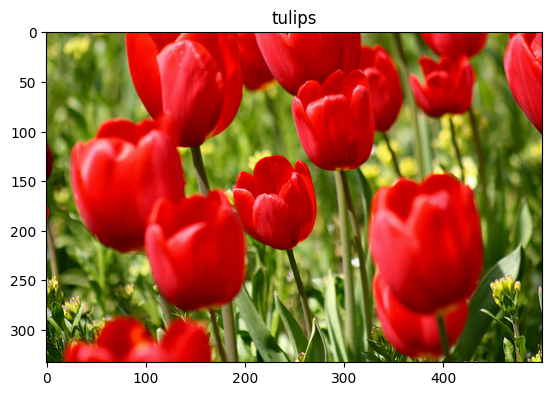

In [35]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

As before, remember to batch, shuffle, and configure the training, validation, and test sets for performance:

In [36]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

You can find a complete example of working with the Flowers dataset and TensorFlow Datasets by visiting the [Data augmentation](../images/data_augmentation.ipynb) tutorial.

## Next steps

This tutorial showed two ways of loading images off disk. First, you learned how to load and preprocess an image dataset using Keras preprocessing layers and utilities. Next, you learned how to write an input pipeline from scratch using `tf.data`. Finally, you learned how to download a dataset from TensorFlow Datasets.

For your next steps:

- You can learn [how to add data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation).
- To learn more about `tf.data`, you can visit the [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data) guide.